# Produce a warp

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget

Define surface:

$z = h_1 \, r^{1+hr\_index}$

In [69]:
h1 = 0.05
hr_index = 0.25

Define the warp (inclination for each ring): logistic function from $i=0$ outside transitioning to `inc_max` at radius `r0` over a transition width of `dr`.

In [72]:
inc_max = np.pi / 6
dr = 0.1
r0 = 1

Calculate the surface edges and centers

In [73]:
nphi = 50 # number of points along azimuth
nr  = 20  # number of rings

In [119]:
# define cylindrical radius, azimuthal angle, and height above mid plane
r   = np.ones([nr, nphi]) * np.linspace(.2, 2, nr)[:, None]
phi = np.ones([nr, nphi]) * np.linspace(0, 2 * np.pi, nphi)
z   = h1 * r**(1 + hr_index)

# define centers as well
rc   = 0.5 * (r[1:, 1:] + r[:-1, 1:])
zc   = h1 * rc**(1 + hr_index)
phic = 0.5 * (phi[1:, 1:] + phi[1:, :-1])

# convert to cartesian

x   = r * np.cos(phi)
y   = r * np.sin(phi)

xc   = rc * np.cos(phic)
yc   = rc * np.sin(phic)

# calculate warp inclinations
inc   = inc_max / (1.0 + np.exp((r[:, 0] - r0) / dr))
inc_c = 0.5 * (inc[1:] + inc[:-1])

Define a single point + velocity vector for testing

In [ ]:
r_point = rc[-1, -1]
phi_point = phic[-1, -1]
x_point = r_point * np.cos(phi_point)
y_point = r_point * np.sin(phi_point)
v_point = 

Define each radius' twist

In [122]:
rot = np.linspace(0, 20, nr) * np.pi / 180.
rot_c = 0.5 * (rot[1:] + rot[:-1])

Making an array of the coordinates that is `(nr, nphi, 3)`

In [123]:
points = np.moveaxis([x, y, z], 0, 2)
points_c = np.moveaxis([xc, yc, zc], 0, 2)

Define the rotation matrices

In [124]:
def Rx(theta):
    nt = len(np.array(theta, ndmin=1))
    cos = np.cos(theta)
    sin = np.sin(theta)
    R = (np.eye(3)[:, :, None] * np.ones([3, 3, nt]))
    R[1, 1, :] = cos
    R[2, 2, :] = cos
    R[1, 2, :] = -sin
    R[2, 1, :] = sin
    return R
    
def Ry(theta):
    nt = len(np.array(theta, ndmin=1))
    cos = np.cos(theta)
    sin = np.sin(theta)
    R = (np.eye(3)[:, :, None] * np.ones([3, 3, nt]))
    R[0, 0, :] = cos
    R[0, 2, :] = sin
    R[2, 0, :] = -sin
    R[2, 2, :] = cos
    return R

def Rz(theta):
    nt = len(np.array(theta, ndmin=1))
    cos = np.cos(theta)
    sin = np.sin(theta)
    R = (np.eye(3)[:, :, None] * np.ones([3, 3, nt]))
    R[0, 0, :] = cos
    R[0, 1, :] = -sin
    R[1, 0, :] = sin
    R[1, 1, :] = cos
    return R

apply the ring inclination

In [125]:
points1 = np.einsum('ijk,klj->kli', Ry(inc), points)
points1_c = np.einsum('ijk,klj->kli', Ry(inc_c), points_c)

apply the twist

In [126]:
points2 = np.einsum('ijk,klj->kli', Rz(rot), points1)
points2_c = np.einsum('ijk,klj->kli', Rz(rot_c), points1_c)

Plot original and new rings

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
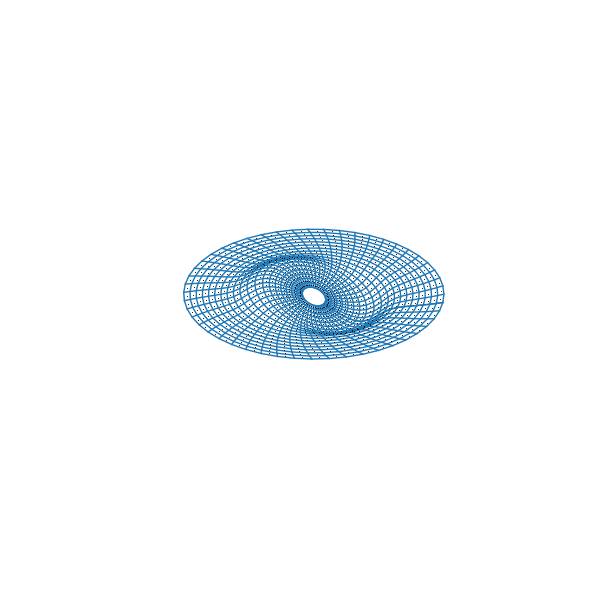

In [133]:
with plt.rc_context({'lines.linewidth': 1}):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(projection='3d')

    #ax.plot(x, y, z)

    for i, _points in enumerate([points2]):

        for ir in range(nr):
            _x, _y, _z = _points[ir].T
            ax.plot(_x, _y, _z, c=f'C{i}')

        for iphi in range(nphi):
            _x, _y, _z = _points[:, iphi, :].T
            ax.plot(_x, _y, _z, c=f'C{i}')
            
    for iphi in range(nphi - 1):
        _x, _y, _z = points2_c[:, iphi, :].T
        ax.plot(_x, _y, _z, ls='none', marker='.', mfc='k', mec='none', markersize=1.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_zlim([-2, 2])
    ax.axis('off')

### Observer Projection

Default observer is face on, so image plane normal would be (0,0,-1). And the base vectors are
$$
\vec e_x = \pmatrix{1\\0\\0},
\vec e_y = \pmatrix{0\\1\\0}, 
\vec e_z = \pmatrix{0\\0\\-1}\\
$$

In [14]:
ex = (1, 0, 0)
ey = (0, 1, 0)
ez = (0, 0, -1)

base = np.array([ex, ey, ez])

define the inclination of the observer as rotation around x

In [55]:
inc_obs = np.pi / 4
PA_obs = np.pi / 4

In [56]:
R_inc = Rx(inc_obs)

In [57]:
R_PA = Rz(PA_obs)

rotate the base

In [62]:
base2 = R_inc[:, :, 0].dot(R_PA[:, :, 0].dot(base))

project the points

In [63]:
points3 = np.einsum('ijk,kl->ijl',points2, base2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
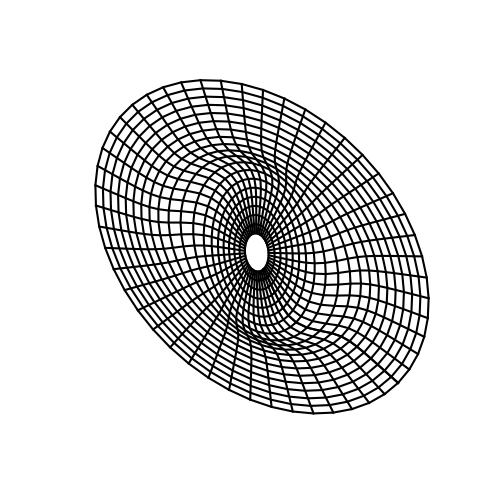

In [67]:
f, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')
ax.axis('off')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

for ir in range(nr):
    _x, _y, _z = points3[ir].T
    ax.plot(_x, _y, c='k')

for iphi in range(nphi):
    _x, _y, _z = points3[:, iphi, :].T
    ax.plot(_x, _y, c='k')

In [12]:
plt.close('all')